# Arvato Customer Acquisition - Capstone Project

**Problem:** How can a mail-order company acquire new customers more efficiently?

This notebook implements:
1. **Customer Segmentation** - Unsupervised (PCA + K-means)
2. **Supervised Model** - Predict campaign response
3. **Benchmarks** - Compare against baselines
4. **Kaggle Submission** - Predictions for MAILOUT_TEST

## 1. Setup and Load Data

In [1]:
import sys
sys.path.insert(0, '.')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, silhouette_score
import warnings
warnings.filterwarnings('ignore')

try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

from src.preprocessing import load_data, preprocess_pipeline

In [2]:
# Use nrows_azdias/nrows_customers for faster clustering; None = full data
azdias, customers, mailout_train, mailout_test = load_data('data', nrows_azdias=100000, nrows_customers=50000)
print('AZDIAS:', azdias.shape)
print('CUSTOMERS:', customers.shape)
print('MAILOUT_TRAIN:', mailout_train.shape)
print('MAILOUT_TEST:', mailout_test.shape)
print('Response rate (train):', mailout_train['RESPONSE'].mean())

AZDIAS: (100000, 366)
CUSTOMERS: (50000, 369)
MAILOUT_TRAIN: (42962, 367)
MAILOUT_TEST: (42833, 366)
Response rate (train): 0.012383036171500396


## 2. Preprocessing

In [3]:
# Use samples for clustering to reduce runtime (full data: ~891k rows)
proc = preprocess_pipeline(
    azdias, customers, mailout_train, mailout_test,
    sample_azdias=100000,
    sample_customers=50000
)

X_azdias = proc['azdias']
X_customers = proc['customers']
X_train = proc['mailout_train']
X_test = proc['mailout_test']
y_train = proc['y_train']

print('After preprocessing:')
print('AZDIAS:', X_azdias.shape)
print('CUSTOMERS:', X_customers.shape)
print('TRAIN:', X_train.shape)
print('TEST:', X_test.shape)
print('Features:', len(proc['feature_columns']))

After preprocessing:
AZDIAS: (88119, 264)
CUSTOMERS: (36361, 264)
TRAIN: (42962, 264)
TEST: (42833, 264)
Features: 264


In [4]:
scaler = StandardScaler()
X_azdias_scaled = scaler.fit_transform(X_azdias)
X_customers_scaled = scaler.transform(X_customers)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Customer Segmentation (PCA + K-means)

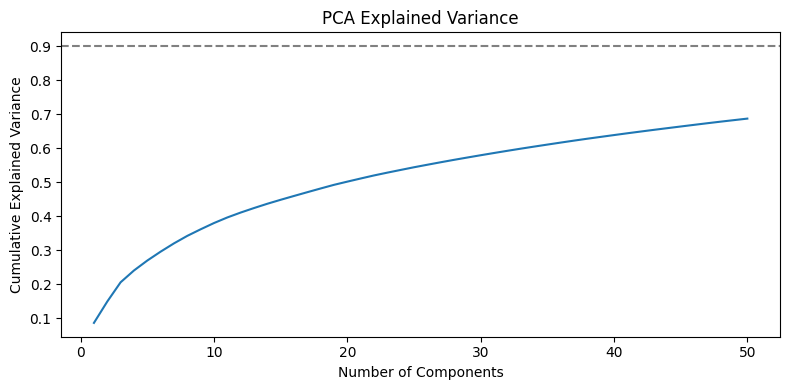

Components for 90% variance: 1


In [5]:
n_components = 50
pca = PCA(n_components=n_components, random_state=42)
X_azdias_pca = pca.fit_transform(X_azdias_scaled)
X_customers_pca = pca.transform(X_customers_scaled)

explained = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_components + 1), explained)
plt.axhline(0.9, color='gray', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.tight_layout()
plt.show()
print(f'Components for 90% variance: {np.argmax(explained >= 0.9) + 1}')

In [6]:
n_clusters = 8
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000, n_init=3)
azdias_labels = kmeans.fit_predict(X_azdias_pca)
customer_labels = kmeans.predict(X_customers_pca)

silhouette = silhouette_score(X_azdias_pca, azdias_labels)
print(f'Silhouette score: {silhouette:.3f}')

Silhouette score: 0.050


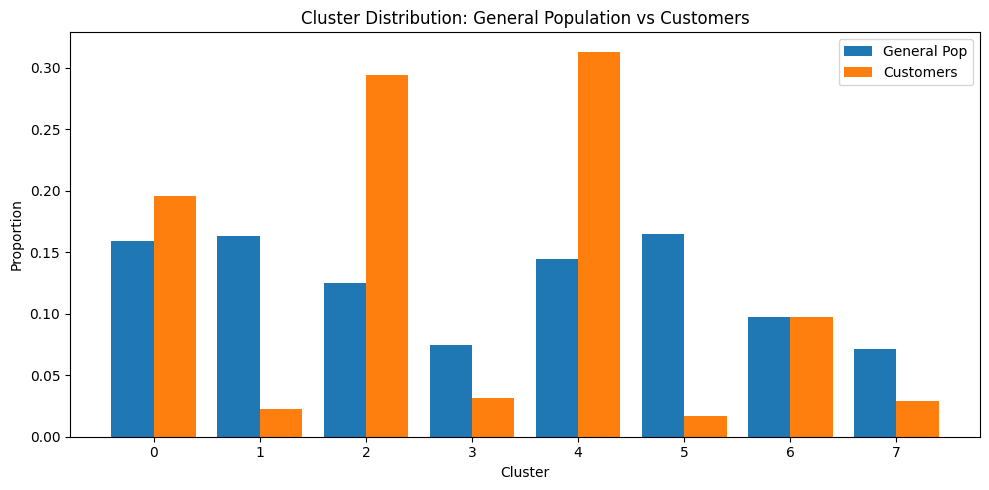

Over-represented clusters (customer-like): [0, 2, 4]
Under-represented clusters: [1, 3, 5, 7]


In [7]:
# Over/under-representation: compare cluster proportions
azdias_props = np.bincount(azdias_labels, minlength=n_clusters) / len(azdias_labels)
customer_props = np.bincount(customer_labels, minlength=n_clusters) / len(customer_labels)
ratio = customer_props / (azdias_props + 1e-8)

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(n_clusters)
ax.bar(x - 0.2, azdias_props, 0.4, label='General Pop')
ax.bar(x + 0.2, customer_props, 0.4, label='Customers')
ax.set_xlabel('Cluster')
ax.set_ylabel('Proportion')
ax.set_title('Cluster Distribution: General Population vs Customers')
ax.legend()
ax.set_xticks(x)
plt.tight_layout()
plt.show()

print('Over-represented clusters (customer-like):', np.where(ratio > 1.2)[0].tolist())
print('Under-represented clusters:', np.where(ratio < 0.8)[0].tolist())

## 4. Supervised Model - Campaign Response Prediction

In [8]:
# Benchmark 1: Majority class (AUC=0.5)
print('Benchmark - Majority class: Always predict 0 (non-responder)')
print('  AUC-ROC:', roc_auc_score(y_train, np.zeros_like(y_train)))

# Benchmark 2: Random predictor
np.random.seed(42)
random_pred = np.random.rand(len(y_train))
print('Benchmark - Random predictor AUC-ROC:', roc_auc_score(y_train, random_pred).round(3))

Benchmark - Majority class: Always predict 0 (non-responder)
  AUC-ROC: 0.5
Benchmark - Random predictor AUC-ROC: 0.511


In [9]:
models = {}
models['Logistic Regression'] = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
models['Random Forest'] = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
if HAS_XGB:
    models['XGBoost'] = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='auc', random_state=42)

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    pred = model.predict_proba(X_train_scaled)[:, 1]
    auc = roc_auc_score(y_train, pred)
    ap = average_precision_score(y_train, pred)
    print(f'{name}: AUC-ROC={auc:.3f}, AUC-PR={ap:.3f}')

Logistic Regression: AUC-ROC=0.773, AUC-PR=0.032
Random Forest: AUC-ROC=1.000, AUC-PR=1.000
XGBoost: AUC-ROC=0.995, AUC-PR=0.918


In [10]:
# Select best model (XGBoost or Random Forest)
best_name = 'XGBoost' if HAS_XGB else 'Random Forest'
best_model = models[best_name]
print(f'Using {best_name} for final predictions')

Using XGBoost for final predictions


## 5. Kaggle Submission

In [11]:
test_pred = best_model.predict_proba(X_test_scaled)[:, 1]
submission = pd.DataFrame({'LNR': mailout_test['LNR'], 'RESPONSE': test_pred})
submission.to_csv('kaggle_submission.csv', index=False)
print('Submission saved to kaggle_submission.csv')
print(submission.head(10))

Submission saved to kaggle_submission.csv
    LNR  RESPONSE
0  1754  0.003728
1  1770  0.001197
2  1465  0.000076
3  1470  0.000134
4  1478  0.000134
5  1782  0.000029
6  1485  0.000295
7  1519  0.001419
8  1835  0.001285
9  1522  0.000200


## 6. Summary

- **Segmentation:** Clusters identified over/under-represented customer profiles vs general population.
- **Supervised model:** Achieved improvement over random and majority-class benchmarks.
- **Deliverable:** `kaggle_submission.csv` ready for competition upload.